In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.hooks as hooks
import transformer_lens.hook_points as hp

c:\Users\aidan\Documents\Programming\autocircuit\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class MLP(nn.Module):
    def __init__(self, input, hidden, output):
        super().__init__()
        self.fc1 = nn.Linear(input, hidden)
        self.fc2 = nn.Linear(hidden, output)

        self.h0 = hp.HookPoint()
        self.h1 = hp.HookPoint()
        self.h2 = hp.HookPoint()
    
    def forward(self, x):
        x = self.h0(x)
        x = self.h1(F.relu(self.fc1(x)))
        return self.h2(self.fc2(x))
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=1, std=0.02)
                nn.init.normal_(m.bias, std=0.02)

In [3]:
import autocircuit.graphed_model as gm

In [4]:
class NeuronHook:
    def __init__(self, hook_point, index):
        self.hook_point = hook_point
        self.index = index
    
    def add_hook(self, fn):
        def go(tensor, hook=None):
            out = fn(tensor[:, self.index], hook=hook)
            tensor[:, self.index] = out
            return tensor
        self.hook_point.add_hook(go)

In [5]:
class MLPGraph(gm.GraphedModel):
    def __init__(self, input, hidden, output):
        super().__init__()
        self.mlp = MLP(input, hidden, output)
        self._graph = gm.ComputeGraph({}, [], "output")

        for o in range(output):
            self._graph.nodes[f"output_{o}"] = NeuronHook(self.mlp.h2, o)
        for h in range(hidden):
            self._graph.nodes[f"hidden_{h}"] = NeuronHook(self.mlp.h1, h)
        for i in range(input):
            self._graph.nodes[f"input_{i}"] = NeuronHook(self.mlp.h0, i)
        
        self._graph.nodes["output"] = self.mlp.h2
        
        self._graph.edges = [(f"output_{o}", f"hidden_{h}") for o in range(output) for h in range(hidden)]
        self._graph.edges += [("output", f"output_{o}") for o in range(output)]
        self._graph.edges += [(f"hidden_{h}", f"input_{i}") for h in range(hidden) for i in range(input)]

    @property
    def graph(self):
        return self._graph
    
    def __call__(self, x):
        return self.graph.run(x)
    
    def run_with_hooks(self, x, fwd_hooks):
        for name, fn in fwd_hooks:
            name.add_hook(fn)
        output = self.mlp(x)
        self.mlp.h0.remove_hooks()
        self.mlp.h1.remove_hooks()
        self.mlp.h2.remove_hooks()
        return output

In [6]:
model = MLPGraph(1, 4, 1)

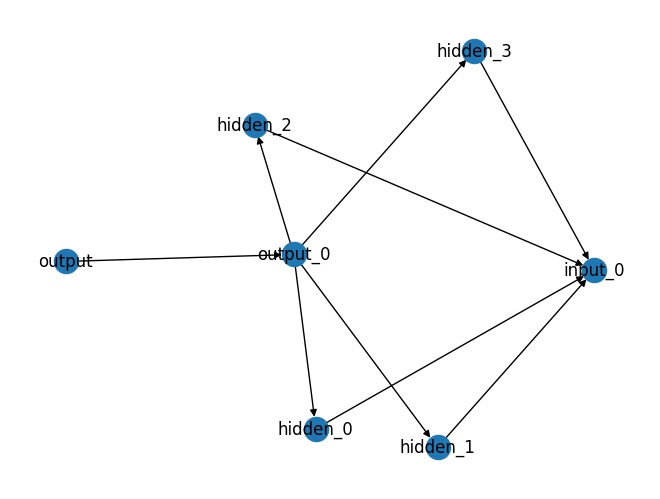

In [7]:
import autocircuit.visualise as vis

vis.draw_graph(model.graph)

In [8]:
# train the model to calculate x**2
import torch.optim as optim

model.mlp.h0.remove_hooks()
model.mlp.h1.remove_hooks()
model.mlp.h2.remove_hooks()

opt = optim.Adam(model.mlp.parameters(), lr=0.01)

for i in range(1000):
    opt.zero_grad()
    x = torch.rand(1, 1)
    y = x ** 2
    out = model.mlp(x)
    loss = F.mse_loss(out, y)
    loss.backward()
    opt.step()

In [9]:
import autocircuit as ac

In [11]:
ac_cache = {}
cache_hooks = []

def hook_node(node):
    def go(tensor, hook=None):
        print(node)
        ac_cache[node] = tensor
        return tensor
    return go

for node in model.graph.nodes:
    cache_hooks.append((model.graph.nodes[node], hook_node(node)))

with torch.no_grad():
    model.run_with_hooks(torch.randn(1, 1), cache_hooks)

print(ac_cache)

input_0
input_0
hidden_0
hidden_1
hidden_2
hidden_3
hidden_0
hidden_1
hidden_2
hidden_3
output_0
output
output_0
output
{'input_0': tensor([-0.3535]), 'hidden_0': tensor([0.]), 'hidden_1': tensor([0.7056]), 'hidden_2': tensor([0.]), 'hidden_3': tensor([0.]), 'output_0': tensor([-0.0364]), 'output': tensor([[-0.0364]])}


In [12]:
print(model.graph.get_children("output_0"))

['hidden_0', 'hidden_1', 'hidden_2', 'hidden_3']


In [13]:
print(F.mse_loss(torch.tensor([[0.2762]]), torch.tensor([[-0.2193]])))

tensor(0.2455)


In [15]:
out = ac.autocircuit(model, model.graph, "output", torch.tensor([[0.5]], dtype=torch.float), ac_cache, 0, diff_fn=F.mse_loss)

looking at child output_0 of output
tensor([[-0.0364]], grad_fn=<CopySlices>) tensor([[0.2287]], grad_fn=<AddmmBackward0>)
output has important children ['output_0'] and mean diff 0.0702664777636528
looking at child hidden_0 of output_0
tensor([[0.0638]], grad_fn=<AddmmBackward0>) tensor([[0.2287]], grad_fn=<AddmmBackward0>)
looking at child hidden_1 of output_0
tensor([[0.1285]], grad_fn=<AddmmBackward0>) tensor([[0.2287]], grad_fn=<AddmmBackward0>)
looking at child hidden_2 of output_0
tensor([[0.2287]], grad_fn=<AddmmBackward0>) tensor([[0.2287]], grad_fn=<AddmmBackward0>)
looking at child hidden_3 of output_0
tensor([[0.2287]], grad_fn=<AddmmBackward0>) tensor([[0.2287]], grad_fn=<AddmmBackward0>)
output_0 has important children ['hidden_0', 'hidden_1'] and mean diff 0.009306049905717373
looking at child input_0 of hidden_0
tensor([[-0.0364]], grad_fn=<AddmmBackward0>) tensor([[0.2287]], grad_fn=<AddmmBackward0>)
hidden_0 has important children ['input_0'] and mean diff 0.070266477

In [16]:
print(out.nodes)

{'output_0': <__main__.NeuronHook object at 0x000001FCFB2AB7D0>, 'hidden_0': <__main__.NeuronHook object at 0x000001FCFB2AAC10>, 'hidden_1': <__main__.NeuronHook object at 0x000001FCFB2AAB50>, 'input_0': <__main__.NeuronHook object at 0x000001FCFB2AA690>, 'output': HookPoint()}


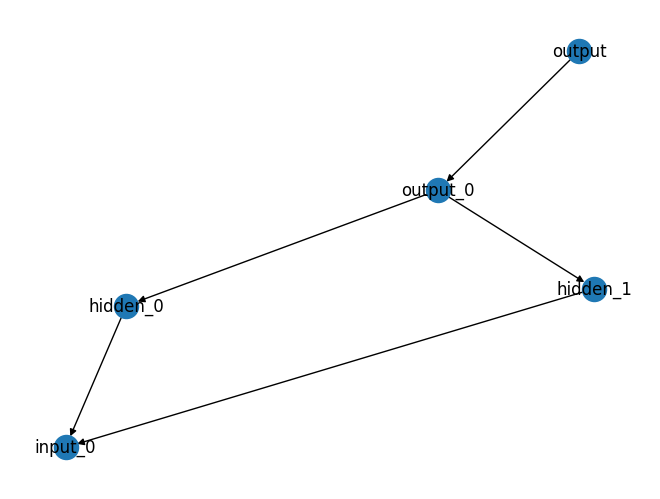

In [17]:
vis.draw_graph(out)